# Artificial Neural Networks Vs. Physics-Informed Neural networks

By David Ortiz and Rodrigo Salas, 2024

Read the seminal PINNs paper [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).

## Activity overview

In this activity, we will code an Artificial Neural Network (ANN) and a Physics-Informed Neural Network (PINN) to solve the nonlinear mathematical model of an **oscillating pendulum**. This will allow us to explore the benefits of incorporating physical models into the loss function.

## Activity goals

By the end of this activity, you should be able to:

 - understand the need of numerical solution to complex models
 - understand the advantages of using Physics-Informed Neural Networks (PINNs) compared to common Artificial Neural Networks (ANN)
 - train data-driven PINNs using PyTorch
 - solve non-linear models using PINNs


## Mathematical description of the problem
We want to solve the mathematical problem related to the **oscillating pendulum**[(wiki)](https://en.wikipedia.org/wiki/Pendulum_(mechanics)):


| ![GIF](../data/figures/Oscillating_pendulum.gif) | <img src="../data/figures/Pendulum_gravity.svg" alt="Diagrama del proyecto" width="300"/> |
|-------------------------------------------|-------------------------------------------|
| Pendulum velocity and acceleration vectors  | Force diagram |


Assumptions:
- the rod is rigid and massless [(Homework)](https://en.wikipedia.org/wiki/Elastic_pendulum#:~:text=In%20physics%20and%20mathematics%2C%20in,%2Ddimensional%20spring%2Dmass%20system.)
- the weight is a point mass
- two dimensions [(Homework)](https://www.instagram.com/reel/CffUr64PjCx/?igsh=MWlmM2FscG9oYnp6bw%3D%3D)
- no air resistance [(Homework)](https://www.youtube.com/watch?v=erveOJD_qv4&ab_channel=Lettherebemath)
- gravitational field is uniform and the support does not move

We are interested in find the vertical angle $\theta(t) \in [0, 2\pi)$ such that:

$$
\frac{d^2\theta}{dt^2}+\frac{g}{l}\sin\theta=0,\quad\theta(0)=\theta_0,\quad\theta'(0)=0,\quad t\in\mathbb{R}, 
$$

where $g\approx9.81m/s^2$, $l$ is the length of the rod and $t$ the temporal variable.

Review on differential equations:
- Why is this a non-linear differential equation?
- It is an ordinary differential equation (ODE) or a partial differential equation (PDE)?
- Which is the order, Which is the degree?

A usefull method is to convert the model to a coupled system of EDOs:

$$
\begin{align*}
\frac{d\theta}{dt} &= \omega, \quad \text{angular velocity}\\
\frac{d\omega}{dt} & = -\frac{g}{l}\sin\theta, \quad \text{angular acceleration}
\end{align*}
$$

## Workflow:

The workflow for this activity will be the following:

1. run a numerical solver. We will use the numerical solution as trining data
2. train an ANN and show the solution. Play with training parameters to improve the outcome
3. train a PINN and show the solution. Change training parameters and train a data-free model
4. further discussion



## Initial setup

We begin by importing some usefull packages, and defining some functions

In [1]:
%matplotlib widget

In [2]:
# Import NumPy for numerical operations
import numpy as np
# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
# Import Matplotlib for plotting
import matplotlib.pyplot as plt
# Import a utility module 
import utils 
# Import the time module to time our training process
import time
# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

# Function to calculate the signal-to-noise ratio
def calculate_snr(signal, noise):    
    # Ensure numpy arrays
    signal, noise = np.array(signal), np.array(noise)
    
    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    
    # Calculate the SNR in decibels (dB)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate the relative l2 error
def relative_l2_error(u_num, u_ref):
    # Calculate the L2 norm of the difference
    l2_diff = torch.norm(u_num - u_ref, p=2)
    
    # Calculate the L2 norm of the reference
    l2_ref = torch.norm(u_ref, p=2)
    
    # Calculate L2 relative error
    relative_l2 = l2_diff / l2_ref
    return relative_l2

# Function to plot the solutions
def plot_comparison(time, theta_true, theta_pred, loss):
    
    # Convert tensors to numpy arrays for plotting
    t_np = time.detach().numpy()
    theta_pred_np = theta_pred.detach().numpy()

    # Create a figure with 2 subplots
    _, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the true and predicted values
    axs[0].plot(t_np, theta_true, label = r'$\theta(t)$ (numerical solution)')
    axs[0].plot(t_np, theta_pred_np, label = r'$\theta_{pred}(t)$ (predicted solution) ')
    axs[0].set_title('Angular displacement Numerical Vs. Predicted')
    axs[0].set_xlabel(r'Time $(s)$')
    axs[0].set_ylabel('Amplitude') 
    axs[0].legend(loc='lower left', frameon=False)


    # Plot the difference between the predicted and true values
    difference = np.abs(theta_true.reshape(-1,1) - theta_pred_np.reshape(-1,1))
    axs[1].plot(t_np, difference)
    axs[1].set_title('Absolute Difference')
    axs[1].set_xlabel(r'Time $(s)$')
    axs[1].set_ylabel(r'$|\theta(t) - \theta_{pred}(t)|$')
    # Display the plot
    plt.legend(loc='best', frameon=False)
    plt.tight_layout()
    plt.show()

    # Plot the loss values recorded during training
    # Create a figure with 1 subplots
    _, axs = plt.subplots(1, 1, figsize=(6, 3))
    axs.plot(loss)
    axs.set_xlabel('Iteration')
    axs.set_ylabel('Loss')
    axs.set_yscale('log')
    axs.set_xscale('log')
    axs.set_title('Training Progress')
    axs.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect 
    to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, 
                        grad_outputs=torch.ones_like(outputs), 
                        create_graph=True,
                        )[0]


### Numerical solution
For the numerical solution we use the [Runge-Kutta of forth order](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) from `scipy`. We begin by defining the parameters for this example, the pendulum model, and the domain:

In [3]:
g = 9.81  # gravity acceleration (m/s^2)
L = 1.0   # Pendulum's rod length (m)
theta0 = np.pi / 4  # Initial condition (Position in rads)
omega0 = 0.0        # Initial angular speed (rad/s)

# Simulation time (sample rate 100Hz)
t_span = (0, 10)  # from 0 to 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Points to be evaluated

# We define the system of coupled ODEs
def pendulum(t, y):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return [dtheta_dt, domega_dt]

# Initial conditions
y0 = [theta0, omega0]

Now, we solve the problem numerically using `scipy`

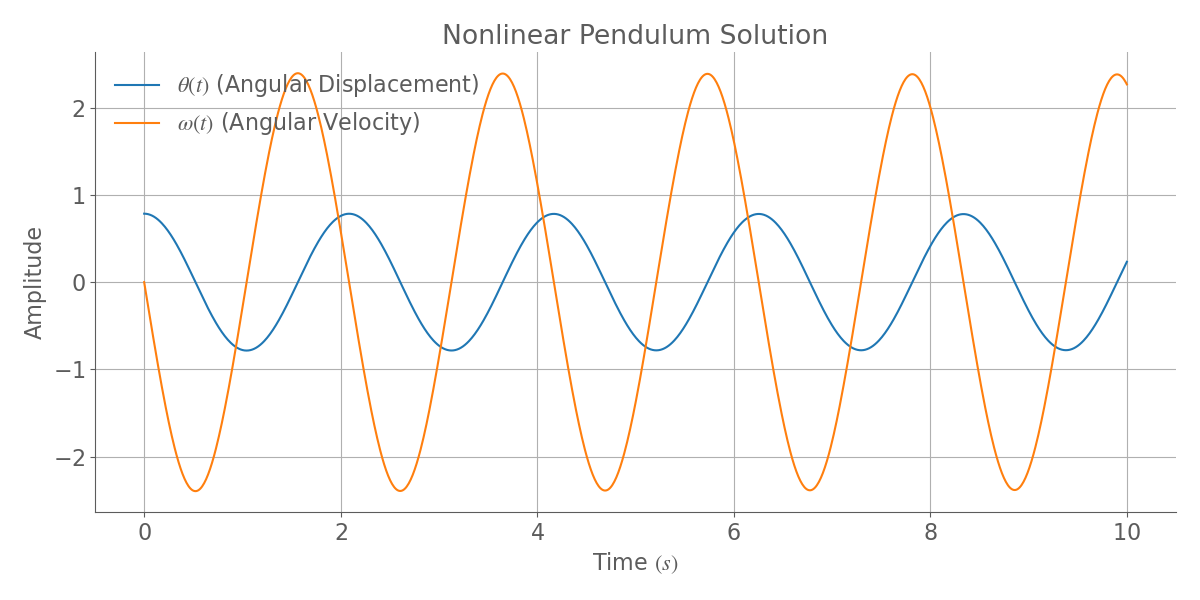

In [4]:
from scipy.integrate import solve_ivp

# Solve the initial value problem using Runge-Kutta 4th order
sol = solve_ivp(pendulum, t_span, y0, t_eval=t_eval, method='RK45')

# We extract the solutions
theta = sol.y[0]
omega = sol.y[1]

# We graph the results
plt.figure(figsize=(12, 6))
plt.plot(t_eval, theta, label=r'$\theta(t)$ (Angular Displacement)')
plt.plot(t_eval, omega, label=r'$\omega(t)$ (Angular Velocity)')
plt.xlabel(r'Time $(s)$')
plt.ylabel('Amplitude')
plt.legend(loc='best', frameon=False)
plt.title('Nonlinear Pendulum Solution')
plt.grid(True)
plt.tight_layout()
plt.show()

## Training the Artificial Neural Network

In the following, we consider the numerical solution as the **training data**. We add gaussian noise, subsample and cut the data to $2.5s$ to test the performance of the ANN. Also, we calculate the signal-to-noise ratio $SNR = 10\log_{10} \left(\frac{P_{signal}}{P_{noise}}\right)$, where $P_{signal}$ and $P_{noise}$ are the power of the signal and the noise, respectively, to get the amount of distortion in the signal. We call the noisy training data $\theta_{data}(t)$

SNR: 20.9024 dB


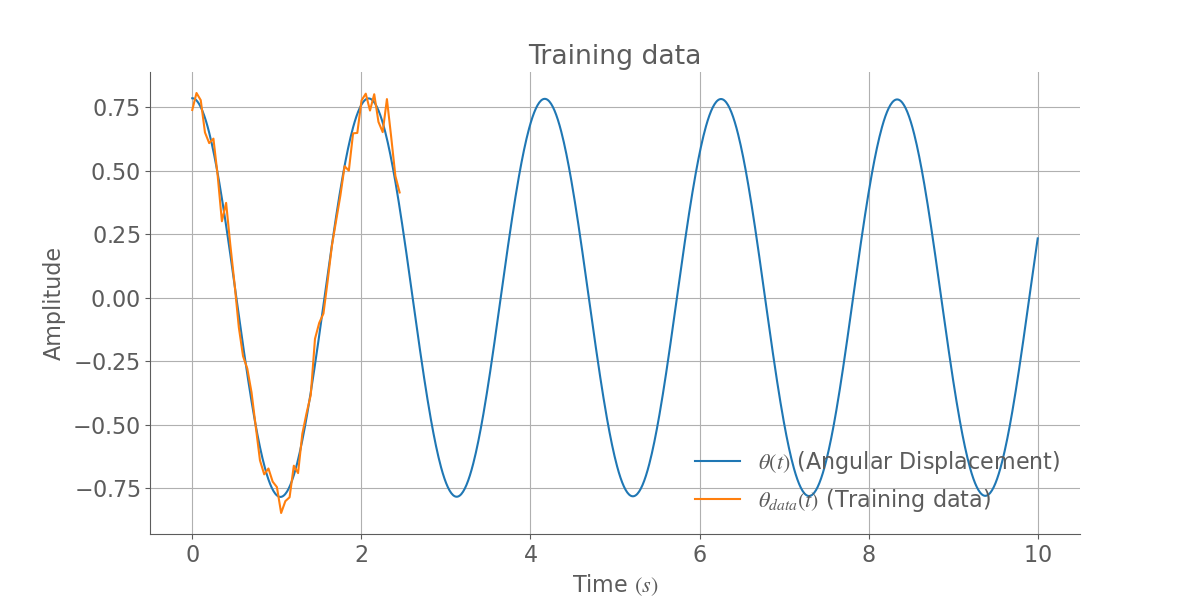

In [5]:
# Add gaussian noise
sigma = 0.05
noise = np.random.normal(0,sigma,theta.shape[0])
theta_noisy = theta + noise
print(f'SNR: {calculate_snr(theta_noisy, noise):.4f} dB')

# Resample and cut to 2.5s
resample = 5          # resample 
ctime = int(2.5*100)  # 2.5s times 100Hz

theta_data = theta_noisy[:ctime:resample]
t_data = t_eval[:ctime:resample]

# We graph the observed data
plt.figure(figsize=(12, 6))
plt.plot(t_eval, theta, label=r'$\theta(t)$ (Angular Displacement)')
plt.plot(t_data, theta_data, label=r'$\theta_{data}(t)$ (Training data)')
plt.xlabel(r'Time $(s)$')
plt.ylabel('Amplitude')
plt.legend(loc='lower right', frameon=False)
plt.title('Training data')
plt.grid(True)
plt.show()

We train the artificial neural network to directly approximate the solution to the differential equation, i.e.,

$$
\theta_{NN}(t; \Theta) \approx \theta(t)
$$

where $\Theta$ are the free (trainable) parameters of the ANN. Now, we use `PyTorch` and define the neural network and, for this task, we will use the ADAM optimizer. Also, we convert the temporal domain and the observations to `torch.tensors`

In [6]:
torch.manual_seed(123)

# training parameters
hidden_layers = [1, 50, 50, 50, 1]
learning_rate = 0.001
training_iter = 50000

In [7]:

# Define a loss function (Mean Squared Error) for training the network
MSE_func = nn.MSELoss()

# Convert the NumPy arrays to PyTorch tensors and add an extra dimension
# test time Numpy array to Pytorch tensor
t_phys = torch.tensor(t_eval, requires_grad=True).float().reshape(-1,1)
# train time Numpy array to Pytorch tensor
t_data = torch.tensor(t_data, requires_grad=True).float().reshape(-1,1)
# Numerical theta to test Numpy array to pytorch tensor 
theta_test = torch.tensor(theta, requires_grad=True).float().reshape(-1,1)
# Numerical theta to train Numpy array to pytorch tensor 
theta_data = torch.tensor(theta_data, requires_grad=True).float().reshape(-1,1)

# Define a neural network class with user defined layers and neurons
class NeuralNetwork(nn.Module):
    
    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))
        
        self.layers = nn.Sequential(*layers)
        self.init_params
        
    def init_params(self):
        """Xavier Glorot parameter initialization of the Neural Network
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)


In [8]:
# Create an instance of the neural network 
theta_nn = NeuralNetwork(hidden_layers)
nparams = sum(p.numel() for p in theta_nn.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(theta_nn.parameters(), lr=0.001, 
                       betas= (0.9,0.999), eps = 1e-8)

Number of trainable parameters: 5251


### Loss function
To train the ANN, it is mandatory to define the loss function. To this end, we consider the noisy data $\theta_{data}(t)$ and use the mean squared error ($MSE$) over the colocation points (samples over the domain) $\{t_i\}_N$, i.e.,

$$
\mathcal{L}(\Theta) := \lambda_1 MSE(\theta_{NN}(t; \Theta), \theta_{data}(t)) = \frac{\lambda_1}{N}\sum_i (\theta_{NN}(t_i; \Theta) - \theta_{data}(t_i))^2
$$

where $\lambda_1\in\mathbb{R}^+$ is a positive (weigth) number, and $N$ is the number of samples. The training is performed by minimizing the loss function $\mathcal{L}(\Theta)$, i.e.,

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$


Now, we use `PyTorch` and define the neural network, the function loss and, for this task, we will use the ADAM optimizer. Also, we convert the temporal domain and the observations to `torch.tensors`

In [9]:
def NeuralNetworkLoss(forward_pass, t, theta_data, lambda1 = 1):
    
    theta_nn = forward_pass(t)
    data_loss = lambda1 * MSE_func(theta_nn, theta_data)
    
    return  data_loss
    
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(training_iter):
    
    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = NeuralNetworkLoss(theta_nn,
                             t_data,
                             theta_data)    # must be (1. nn output, 2. target)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")
    
    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")


Iteration 0: Loss 0.4117511510848999
Iteration 1000: Loss 0.0021558685693889856
Iteration 2000: Loss 0.002049698494374752
Iteration 3000: Loss 0.0020026573911309242
Iteration 4000: Loss 0.0019549282733350992
Iteration 5000: Loss 0.0017670904053375125
Iteration 6000: Loss 0.0016056295717135072
Iteration 7000: Loss 0.001545777078717947
Iteration 8000: Loss 0.001516319694928825
Iteration 9000: Loss 0.001494777505286038
Iteration 10000: Loss 0.0014725291403010488
Iteration 11000: Loss 0.0014439886435866356
Iteration 12000: Loss 0.001404708600603044
Iteration 13000: Loss 0.0012890493962913752
Iteration 14000: Loss 0.0011887905420735478
Iteration 15000: Loss 0.0011421007802709937
Iteration 16000: Loss 0.0011041220277547836
Iteration 17000: Loss 0.001082256785593927
Iteration 18000: Loss 0.0010659126564860344
Iteration 19000: Loss 0.0010307863121852279
Iteration 20000: Loss 0.0009104415075853467
Iteration 21000: Loss 0.0006130406982265413
Iteration 22000: Loss 0.0005325443926267326
Iteration 

and we plot the results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Relative error: 0.9146906137466431


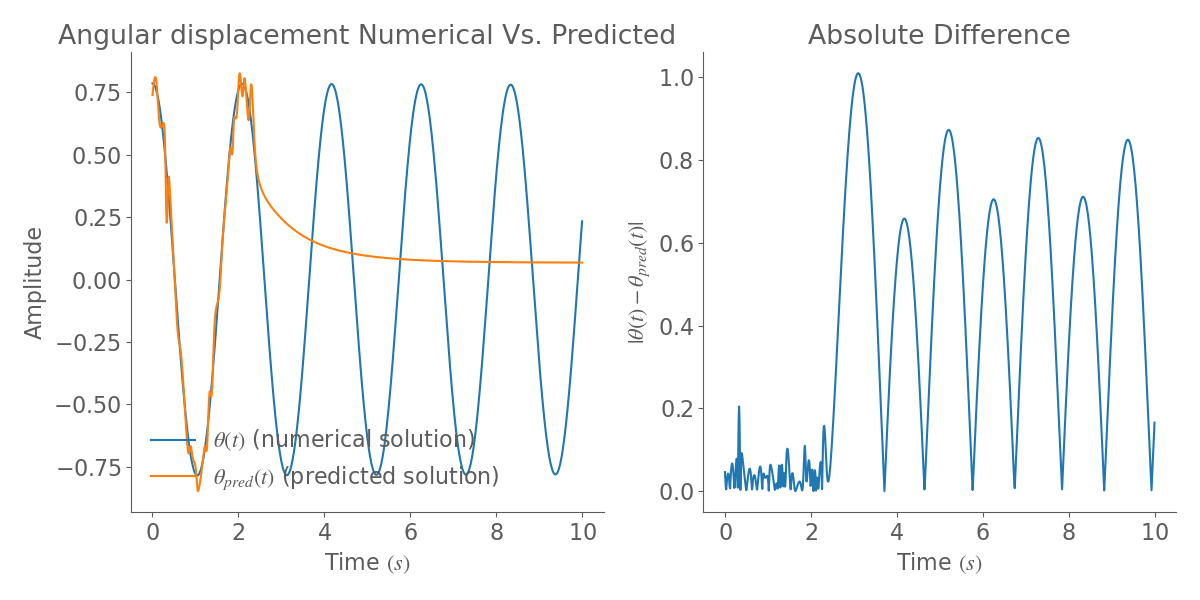

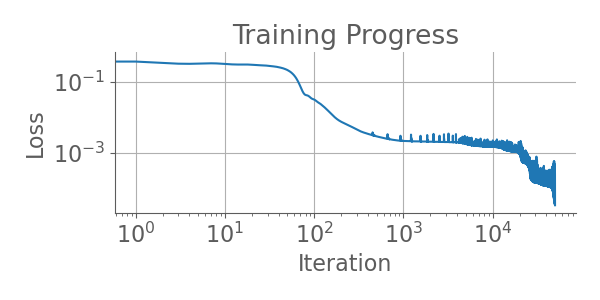

In [10]:
theta_pred = theta_nn(t_phys)

print(f'Relative error: {relative_l2_error(theta_pred, theta_test)}')

plot_comparison(t_phys, theta, theta_pred, loss_values)

**Exercise**:
1. try changing the `sigma`, the `resample` and the `ctime` variables to lower or higher values and test the performance of the ANN
2. increase and decrease the `lambda1` parameters of the loss function
3. increase and reduce the learning rate of the optimizer
4. change the architecture of the ANN
5. increase the number of training iterations

## Training the Physics-Informed Neural Network
For this task we use the same noisy **training data** but in this case, we train the PINN to directly approximate the solution to the differential equation, i.e.,

$$
\theta_{PINN}(t; \Theta) \approx \theta(t)
$$

In [11]:
# Create an instance of the neural network
theta_pinn = NeuralNetwork(hidden_layers)
nparams = sum(p.numel() for p in theta_pinn.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(theta_pinn.parameters(), lr=0.001, 
                       betas= (0.9,0.999), eps = 1e-8)

Number of trainable parameters: 5251


### Physics-Informed Loss function
To train the PINN, we recall the pendulum model and define function $f_{ode}(t;g,l)$, $g_{ic}(0)$ and $h_{bc}(0)$ for the ODE, the initial condition and the boundary condition. Also, we replace the analytical solution $\theta(t)$ with the PINN output $\theta_{pinn}(t; \Theta)$:

$$
\begin{align*}
f_{ode}(t;\theta_{pinn}):=&\frac{d^2\theta_{PINN}(t; \Theta)}{dt^2}+\frac{g}{l}\sin(\theta_{pinn}(t; \Theta)) = 0\\
g_{ic}(0;\theta_{pinn}):=&\theta_{pinn}(0; \Theta) = \theta_0\\
h_{bc}(0;\theta_{pinn}):=&\theta_{pinn}'(0; \Theta) = 0
\end{align*}
$$

Once again we use the $MSE$ and define the physics-informed loss function:

$$
\begin{align*}
\mathcal{L}(\theta):= &\frac{\lambda_1}{N}\sum_i\left(f_{ode}(t_i;\theta_{pinn})-0\right)^2 \quad \text{ODE loss}\\
                   & + \lambda_2 (g_{ic}(0;\theta_{pinn})-\theta_0)^2 \quad \text{IC loss}\\
                   & + \lambda_3 (h_{bc}(0;\theta_{pinn})-0)^2 \quad \text{BC loss}\\
                   & + \frac{\lambda_4}{N}\sum_i (\theta_{pinn}(t_i; \Theta) - \theta_{data}(t_i))^2 \quad \text{DATA loss}
\end{align*}
$$

where $\lambda_{1,2,3,4}\in\mathbb{R}^+$ are positive (weigth) numbers, and $N$ is the number of samples. 

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> when we do not include the loss function related to the data, we are employing a data-free scheme; when we include the data, we are employing a data-driven scheme.
</div>

The training is performed by minimizing the loss function $\mathcal{L}(\Theta)$, i.e.,

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> Autodifferentiation (torch.autograd) is a powerful tool for calculating the gradients of the PINN with respect to its input to evaluate the loss function; for more information, refer to the tutorial.
</div>



In [12]:
# Define t = 0 for boundary an initial conditions 
t0 = torch.tensor(0., requires_grad=True).view(-1,1)

# HINT: 
def PINNLoss(forward_pass, t_phys, t_data, theta_data, 
             lambda1 = 1, lambda2 = 1, lambda3 = 1, lambda4 = 1):

    # ANN output, first and second derivatives
    theta_nn1 = forward_pass(t_phys)
    theta_nn_d = grad(theta_nn1, t_phys)
    theta_nn_dd = grad(theta_nn_d, t_phys)
    
    f_ode = theta_nn_dd + (g/L) * torch.sin(theta_nn1)
    ODE_loss = lambda1 * MSE_func(f_ode, torch.zeros_like(f_ode)) 
    
    g_ic = forward_pass(t0)
    IC_loss = lambda2 * MSE_func(g_ic, torch.ones_like(g_ic)*theta0)
    
    h_bc = grad(forward_pass(t0),t0)
    BC_loss = lambda3 * MSE_func(h_bc, torch.zeros_like(h_bc))
    
    theta_nn2 = forward_pass(t_data)
    data_loss = lambda4 * MSE_func(theta_nn2, theta_data)
    
    return ODE_loss + IC_loss + BC_loss + data_loss
    
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(training_iter):
    
    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = PINNLoss(theta_pinn, t_phys, t_data, theta_data)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")
    
    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Iteration 0: Loss 2.1086533069610596
Iteration 1000: Loss 0.4149186611175537
Iteration 2000: Loss 0.3354986906051636
Iteration 3000: Loss 0.3116246461868286
Iteration 4000: Loss 0.30191168189048767
Iteration 5000: Loss 0.2913457453250885
Iteration 6000: Loss 0.2861419916152954
Iteration 7000: Loss 0.27449581027030945
Iteration 8000: Loss 0.24392732977867126
Iteration 9000: Loss 0.20240551233291626
Iteration 10000: Loss 0.18723714351654053
Iteration 11000: Loss 0.17564530670642853
Iteration 12000: Loss 0.1714382767677307
Iteration 13000: Loss 0.16925939917564392
Iteration 14000: Loss 0.16687527298927307
Iteration 15000: Loss 0.16550235450267792
Iteration 16000: Loss 0.15433552861213684
Iteration 17000: Loss 0.13668709993362427
Iteration 18000: Loss 0.13293085992336273
Iteration 19000: Loss 0.12733393907546997
Iteration 20000: Loss 0.11724290251731873
Iteration 21000: Loss 0.10309481620788574
Iteration 22000: Loss 0.0906234085559845
Iteration 23000: Loss 0.05325176939368248
Iteration 240

Once again, we plot the results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Relative error: 0.015863629058003426


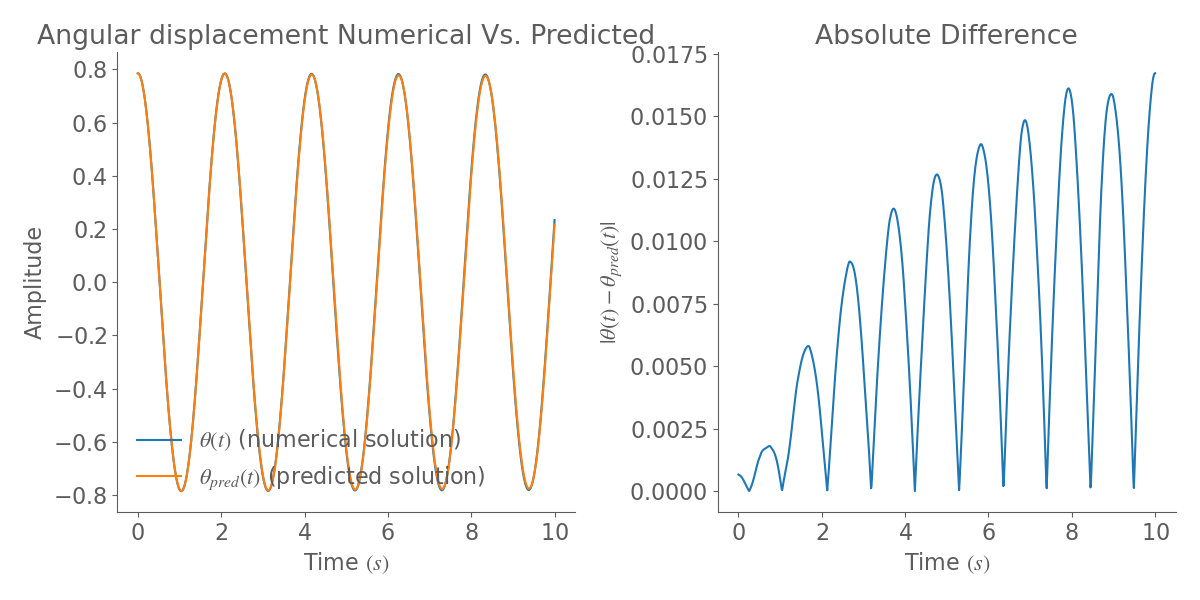

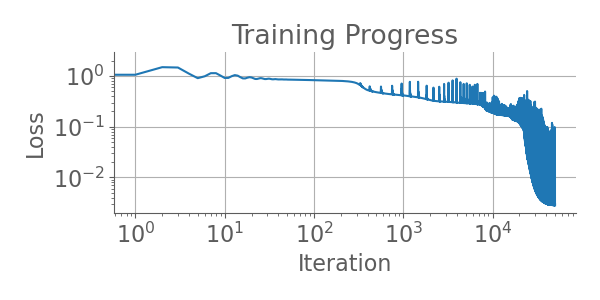

In [14]:
theta_pred = theta_pinn(t_phys)

print(f'Relative error: {relative_l2_error(theta_pred, theta_test)}')

plot_comparison(t_phys, theta, theta_pred, loss_values)

**Exercise**:
1. try changing the `sigma`, the `resample` and the `ctime` variables to lower or higher values and test the performance of the ANN
2. increase and decrease the `lambdas` parameters of the loss function
3. increase and reduce the learning rate of the optimizer
4. change the architecture of the ANN
5. increase the number of training iterations